# Exporting Epochs to Pandas DataFrames

__Citation__

Alexandre Gramfort and Matti S Hämäläinen (2020). MNE Sample Dataset. OpenNeuro. doi: 10.18112/openneuro.ds000248.v1.2.4


Ths notebook describes exporting `mne.Epochs` objects to a `pandas.DataFrame` for further data processing.  The example used is to examine the latencies of the response maxima across epochs and conditions.

In [3]:
import sys
import os
import os.path as op
import numpy as np
import pandas as pd
sys.path.append("../")
from mne_path import PathHandler
ph = PathHandler()
from glob import glob
import random
import mne

pd.set_option("display.max_columns", 200)
%matplotlib inline

# Raw File

In [4]:
# SAMPLE_DATA_DIR = os.path.join(os.environ["HOME"], "mne_data", "MNE-sample-data")
SAMPLE_DATA_DIR = ph.cddir(ph.SAMPLE_DIR)

sample_data_raw_file = os.path.join(SAMPLE_DATA_DIR, 'MEG', 'sample',
                        'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
fif_info = raw.info

Changed to:  /Users/jonghang/mne_data/MNE-sample-data


# Event File

__Preparation Steps__

* Load a list of events from `sample_audvis_filt-0-40_raw-eve.fif`
* map them to condition names with an event dictionary
* set some signal rejection thresholds (cf.`tut-reject-epochs-section`)
* segment the continuous data into epochs.

__Define Event Dictionary & Rejection Criteria__

* mag: 3000 fT
* grad: 3000 fT/cm
* eeg: 100 µV
* eog: 200 µV

In [5]:
reject_criteria = dict(mag = 3000e-15,
                       grad = 3000e-13,
                       eeg = 100e-6,
                       eog = 200e-6)

event_dict = {'auditory/left': 1, 
              'auditory/right': 2, 
              'visual/left': 3,
              'visual/right': 4}

__Retrieve and Process Events__

In [6]:
sample_data_events_file = os.path.join(SAMPLE_DATA_DIR, 'MEG', 'sample',
                           'sample_audvis_filt-0-40_raw-eve.fif')

events = mne.read_events(sample_data_events_file)

tmin, tmax = (-0.2, 0.5)  # epoch from 200 ms before event to 500 ms after it
baseline = (None, 0)      # baseline period from start of epoch to time=0

# Create Epochs Dataset

In [7]:
epochs = mne.Epochs(raw, 
                    events, 
                    event_dict, 
                    tmin, 
                    tmax, 
                    proj = True,
                    baseline = baseline, 
                    reject = reject_criteria, 
                    preload=True)

# optional if memory runs low
# del raw

Not setting metadata
288 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 288 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 003']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 006', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 007']
    Rejecting  epoch based on MAG : ['MEG 1411', 'MEG 1421', 'MEG 1441']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting 

## Converting an `Epochs` object to a `DataFrame`

Each channel's data will be a column of the new `pandas.DataFrame`, alongside three additional columns of event name, epoch number, and sample time. Here we'll just show the first few rows and columns

In [8]:
epoch_df = epochs.to_data_frame()
display(epoch_df.iloc[:5, :20])

,time,condition,epoch,MEG 0113,MEG 0112,MEG 0111,MEG 0122,MEG 0123,MEG 0121,MEG 0132,MEG 0133,MEG 0131,MEG 0143,MEG 0142,MEG 0141,MEG 0213,MEG 0212,MEG 0211,MEG 0222,MEG 0223
0,-0.199795,visual/left,1,21.320252,11.567619,-73.248584,-10.609895,-18.700540,-68.352746,-17.908667,45.379736,-53.123525,10.837026,-17.542068,-71.290885,-66.553255,-15.586660,44.324378,29.821774,19.648534
1,-0.193135,visual/left,1,7.049675,-9.702938,-34.168267,17.480975,-40.182237,-121.225684,2.072452,27.734826,-95.339465,5.517672,2.229642,21.344793,-50.223884,-3.740594,-103.975528,6.674078,25.638868
2,-0.186476,visual/left,1,5.283711,-13.006895,-26.912317,52.130290,-65.157198,-117.842466,6.986073,5.996158,-177.627037,-27.644478,25.034484,-12.820713,-38.154770,3.375589,-196.295801,-15.115647,25.672815
3,-0.179816,visual/left,1,23.040471,1.643716,-37.835772,48.517952,-65.214631,-82.043144,9.672744,1.748030,-211.024973,-33.022703,23.564079,-90.979826,-25.259267,-9.281062,-213.256433,-27.412809,22.815521
4,-0.173156,visual/left,1,25.688943,7.974112,-85.561683,6.450115,-43.778315,-111.795987,17.277138,2.123811,-173.917677,-6.616376,10.932604,-109.440197,-18.387123,-25.417933,-220.592585,-30.508735,9.233991


# Scaling Time and Channel Values

* By default, time values are converted from seconds to milliseconds and then rounded to the nearest integer
* Alternatively, set `time_format=None` if this conversion is undesirable or to keep time as a `float` value in seconds, or convert it to a `pandas.Timedelta` value via `time_format='timedelta'`

Channel measurement values are scaled so that EEG data are converted to µV, magnetometer data are converted to fT, and gradiometer data are converted to fT/cm. These scalings can be customized through `scalings=dict(eeg=1, mag=1, grad=1)`.

In [7]:
epoch_df = epochs.to_data_frame(time_format = None,
                                scalings=dict(eeg = 1, 
                                mag = 1, 
                                grad = 1))

display(epoch_df.iloc[:5, :20])

,time,condition,epoch,MEG 0113,MEG 0112,MEG 0111,MEG 0122,MEG 0123,MEG 0121,MEG 0132,MEG 0133,MEG 0131,MEG 0143,MEG 0142,MEG 0141,MEG 0213,MEG 0212,MEG 0211,MEG 0222,MEG 0223
0,-0.199795,visual/left,1,2.132025e-12,1.156762e-12,-7.324858e-14,-1.060990e-12,-1.870054e-12,-6.835275e-14,-1.790867e-12,4.537974e-12,-5.312352e-14,1.083703e-12,-1.754207e-12,-7.129088e-14,-6.655326e-12,-1.558666e-12,4.432438e-14,2.982177e-12,1.964853e-12
1,-0.193135,visual/left,1,7.049675e-13,-9.702938e-13,-3.416827e-14,1.748098e-12,-4.018224e-12,-1.212257e-13,2.072452e-13,2.773483e-12,-9.533946e-14,5.517672e-13,2.229642e-13,2.134479e-14,-5.022388e-12,-3.740594e-13,-1.039755e-13,6.674078e-13,2.563887e-12
2,-0.186476,visual/left,1,5.283711e-13,-1.300690e-12,-2.691232e-14,5.213029e-12,-6.515720e-12,-1.178425e-13,6.986073e-13,5.996158e-13,-1.776270e-13,-2.764448e-12,2.503448e-12,-1.282071e-14,-3.815477e-12,3.375589e-13,-1.962958e-13,-1.511565e-12,2.567282e-12
3,-0.179816,visual/left,1,2.304047e-12,1.643716e-13,-3.783577e-14,4.851795e-12,-6.521463e-12,-8.204314e-14,9.672744e-13,1.748030e-13,-2.110250e-13,-3.302270e-12,2.356408e-12,-9.097983e-14,-2.525927e-12,-9.281062e-13,-2.132564e-13,-2.741281e-12,2.281552e-12
4,-0.173156,visual/left,1,2.568894e-12,7.974112e-13,-8.556168e-14,6.450115e-13,-4.377831e-12,-1.117960e-13,1.727714e-12,2.123811e-13,-1.739177e-13,-6.616376e-13,1.093260e-12,-1.094402e-13,-1.838712e-12,-2.541793e-12,-2.205926e-13,-3.050873e-12,9.233991e-13


The time values are automatically converted to float in data frame, and the channel values have changed by several orders of magnitude compared to the earlier DataFrame.


# Setting the ``index``

* Set columns (event name, epoch number, and sample time) as index by passing a string or list of strings as the 
* Demonstrate here the effect of `time_format='timedelta'` to yield `pandas.Timedelta` values in the "time" column.



### TimeDelta Data Frame

Use Parameter `time_format='timedelta'` to convert epochs to `Time Delta` version

In [11]:
timedelta_df = epochs.to_data_frame(index = ['condition', 'epoch'],
                                    time_format = 'timedelta')
timedelta_df.iloc[:5, :30]

time   MEG 0113   MEG 0112   
condition   epoch                                                     
visual/left 1     -1 days +23:59:59.800204787  21.320252  11.567619  \
            1     -1 days +23:59:59.806864627   7.049675  -9.702938   
            1     -1 days +23:59:59.813524468   5.283711 -13.006895   
            1     -1 days +23:59:59.820184308  23.040471   1.643716   
            1     -1 days +23:59:59.826844149  25.688943   7.974112   

                    MEG 0111   MEG 0122   MEG 0123    MEG 0121   MEG 0132   
condition   epoch                                                           
visual/left 1     -73.248584 -10.609895 -18.700540  -68.352746 -17.908667  \
            1     -34.168267  17.480975 -40.182237 -121.225684   2.072452   
            1     -26.912317  52.130290 -65.157198 -117.842466   6.986073   
            1     -37.835772  48.517952 -65.214631  -82.043144   9.672744   
            1     -85.561683   6.450115 -43.778315 -111.795987  17.277138   

                    MEG 0133    MEG 0131   MEG 0143   MEG 0142    MEG 0141   
condition   epoch                                                            
visual/left 1      45.379736  -53.123525  10.837026 -17.542068  -71.290885  \
            1      27.734826  -95.339465   5.517672   2.229642   21.344793   
            1       5.996158 -177.627037 -27.644478  25.034484  -12.820713   
            1       1.748030 -211.024973 -33.022703  23.564079  -90.979826   
            1       2.123811 -173.917677  -6.616376  10.932604 -109.440197   

                    MEG 0213   MEG 0212    MEG 0211   MEG 0222   MEG 0223   
condition   epoch                                                           
visual/left 1     -66.553255 -15.586660   44.324378  29.821774  19.648534  \
            1     -50.223884  -3.740594 -103.975528   6.674078  25.638868   
            1     -38.154770   3.375589 -196.295801 -15.115647  25.672815   
            1     -25.259267  -9.281062 -213.256433 -27.412809  22.815521   
            1     -18.387123 -25.417933 -220.592585 -30.508735   9.233991   

                     MEG 0221   MEG 0232   MEG 0233    MEG 0231   MEG 0243   
condition   epoch                                                            
visual/left 1       94.193008  16.173039  11.598142   68.402902 -53.586722  \
            1      -90.168324  -2.769242  65.028595    3.634512 -41.262929   
            1     -189.892666 -26.669405  85.798243  -33.937375 -46.684287   
            1     -220.209998 -41.395890  79.687271  -73.180691 -51.681665   
            1     -273.202733 -39.324798  66.450068 -153.324292 -27.313811   

                     MEG 0242    MEG 0241   MEG 0313   MEG 0312   MEG 0311   
condition   epoch                                                            
visual/left 1       86.109251   87.801113 -12.918468 -32.167849  29.115091  \
            1      137.139203   61.055024  -1.437523 -69.523614  23.020498   
            1      120.022389  -29.683445 -24.052922 -60.393506   8.018939   
            1       57.217508 -138.897046 -36.134853 -26.546888  -2.853249   
            1       14.955000 -176.888284 -15.955402 -37.844454  -4.578409   

                    MEG 0322   MEG 0323  
condition   epoch                        
visual/left 1     -38.921648  16.028165  
            1     -15.423777 -30.760148  
            1      10.669054 -53.716027  
            1      16.255062 -38.527075  
            1      14.898851 -41.565193

### Millisecond Data Frame

Use Parameter `time_format='ms'` to convert epochs to `Milliseconds` version

In [12]:
ms_df = epochs.to_data_frame(index = ['condition', 'epoch'],
                                    time_format = 'ms')
ms_df.iloc[:5, :30]

time   MEG 0113   MEG 0112   MEG 0111   MEG 0122   
condition   epoch                                                     
visual/left 1      -200  21.320252  11.567619 -73.248584 -10.609895  \
            1      -193   7.049675  -9.702938 -34.168267  17.480975   
            1      -186   5.283711 -13.006895 -26.912317  52.130290   
            1      -180  23.040471   1.643716 -37.835772  48.517952   
            1      -173  25.688943   7.974112 -85.561683   6.450115   

                    MEG 0123    MEG 0121   MEG 0132   MEG 0133    MEG 0131   
condition   epoch                                                            
visual/left 1     -18.700540  -68.352746 -17.908667  45.379736  -53.123525  \
            1     -40.182237 -121.225684   2.072452  27.734826  -95.339465   
            1     -65.157198 -117.842466   6.986073   5.996158 -177.627037   
            1     -65.214631  -82.043144   9.672744   1.748030 -211.024973   
            1     -43.778315 -111.795987  17.277138   2.123811 -173.917677   

                    MEG 0143   MEG 0142    MEG 0141   MEG 0213   MEG 0212   
condition   epoch                                                           
visual/left 1      10.837026 -17.542068  -71.290885 -66.553255 -15.586660  \
            1       5.517672   2.229642   21.344793 -50.223884  -3.740594   
            1     -27.644478  25.034484  -12.820713 -38.154770   3.375589   
            1     -33.022703  23.564079  -90.979826 -25.259267  -9.281062   
            1      -6.616376  10.932604 -109.440197 -18.387123 -25.417933   

                     MEG 0211   MEG 0222   MEG 0223    MEG 0221   MEG 0232   
condition   epoch                                                            
visual/left 1       44.324378  29.821774  19.648534   94.193008  16.173039  \
            1     -103.975528   6.674078  25.638868  -90.168324  -2.769242   
            1     -196.295801 -15.115647  25.672815 -189.892666 -26.669405   
            1     -213.256433 -27.412809  22.815521 -220.209998 -41.395890   
            1     -220.592585 -30.508735   9.233991 -273.202733 -39.324798   

                    MEG 0233    MEG 0231   MEG 0243    MEG 0242    MEG 0241   
condition   epoch                                                             
visual/left 1      11.598142   68.402902 -53.586722   86.109251   87.801113  \
            1      65.028595    3.634512 -41.262929  137.139203   61.055024   
            1      85.798243  -33.937375 -46.684287  120.022389  -29.683445   
            1      79.687271  -73.180691 -51.681665   57.217508 -138.897046   
            1      66.450068 -153.324292 -27.313811   14.955000 -176.888284   

                    MEG 0313   MEG 0312   MEG 0311   MEG 0322   MEG 0323  
condition   epoch                                                         
visual/left 1     -12.918468 -32.167849  29.115091 -38.921648  16.028165  
            1      -1.437523 -69.523614  23.020498 -15.423777 -30.760148  
            1     -24.052922 -60.393506   8.018939  10.669054 -53.716027  
            1     -36.134853 -26.546888  -2.853249  16.255062 -38.527075  
            1     -15.955402 -37.844454  -4.578409  14.898851 -41.565193

### Default Seconds Data Frame

Use Parameter `time_format=None` to remain as default `seconds`

In [13]:
epochs_df = epochs.to_data_frame(index = ['condition', 'epoch'],
                                  time_format = None)
epochs_df.iloc[:5, :30]

time   MEG 0113   MEG 0112   MEG 0111   MEG 0122   
condition   epoch                                                         
visual/left 1     -0.199795  21.320252  11.567619 -73.248584 -10.609895  \
            1     -0.193135   7.049675  -9.702938 -34.168267  17.480975   
            1     -0.186476   5.283711 -13.006895 -26.912317  52.130290   
            1     -0.179816  23.040471   1.643716 -37.835772  48.517952   
            1     -0.173156  25.688943   7.974112 -85.561683   6.450115   

                    MEG 0123    MEG 0121   MEG 0132   MEG 0133    MEG 0131   
condition   epoch                                                            
visual/left 1     -18.700540  -68.352746 -17.908667  45.379736  -53.123525  \
            1     -40.182237 -121.225684   2.072452  27.734826  -95.339465   
            1     -65.157198 -117.842466   6.986073   5.996158 -177.627037   
            1     -65.214631  -82.043144   9.672744   1.748030 -211.024973   
            1     -43.778315 -111.795987  17.277138   2.123811 -173.917677   

                    MEG 0143   MEG 0142    MEG 0141   MEG 0213   MEG 0212   
condition   epoch                                                           
visual/left 1      10.837026 -17.542068  -71.290885 -66.553255 -15.586660  \
            1       5.517672   2.229642   21.344793 -50.223884  -3.740594   
            1     -27.644478  25.034484  -12.820713 -38.154770   3.375589   
            1     -33.022703  23.564079  -90.979826 -25.259267  -9.281062   
            1      -6.616376  10.932604 -109.440197 -18.387123 -25.417933   

                     MEG 0211   MEG 0222   MEG 0223    MEG 0221   MEG 0232   
condition   epoch                                                            
visual/left 1       44.324378  29.821774  19.648534   94.193008  16.173039  \
            1     -103.975528   6.674078  25.638868  -90.168324  -2.769242   
            1     -196.295801 -15.115647  25.672815 -189.892666 -26.669405   
            1     -213.256433 -27.412809  22.815521 -220.209998 -41.395890   
            1     -220.592585 -30.508735   9.233991 -273.202733 -39.324798   

                    MEG 0233    MEG 0231   MEG 0243    MEG 0242    MEG 0241   
condition   epoch                                                             
visual/left 1      11.598142   68.402902 -53.586722   86.109251   87.801113  \
            1      65.028595    3.634512 -41.262929  137.139203   61.055024   
            1      85.798243  -33.937375 -46.684287  120.022389  -29.683445   
            1      79.687271  -73.180691 -51.681665   57.217508 -138.897046   
            1      66.450068 -153.324292 -27.313811   14.955000 -176.888284   

                    MEG 0313   MEG 0312   MEG 0311   MEG 0322   MEG 0323  
condition   epoch                                                         
visual/left 1     -12.918468 -32.167849  29.115091 -38.921648  16.028165  
            1      -1.437523 -69.523614  23.020498 -15.423777 -30.760148  
            1     -24.052922 -60.393506   8.018939  10.669054 -53.716027  
            1     -36.134853 -26.546888  -2.853249  16.255062 -38.527075  
            1     -15.955402 -37.844454  -4.578409  14.898851 -41.565193

# Data Frame Transformations Between Long and Wide

* `long_format`:  determines whether each channel's data is in a separate column of the `pandas.DataFrame` (``long_format=False``), 
* `long_format=True` to show whether the measured values are pivoted into a single ``'value'`` column with an extra indicator column for the channel name (``long_format=True``). Passing will also create an extra column ``ch_type`` indicating the channel type.



### Parameter `long_format=False`

In [14]:
wide_df = epochs.to_data_frame(time_format = None, 
                               index = 'condition',
                               long_format = False)
wide_df.head()

,time,epoch,MEG 0113,MEG 0112,MEG 0111,MEG 0122,MEG 0123,MEG 0121,MEG 0132,MEG 0133,MEG 0131,MEG 0143,MEG 0142,MEG 0141,MEG 0213,MEG 0212,MEG 0211,MEG 0222,MEG 0223,MEG 0221,MEG 0232,MEG 0233,MEG 0231,MEG 0243,MEG 0242,MEG 0241,MEG 0313,MEG 0312,MEG 0311,MEG 0322,MEG 0323,MEG 0321,MEG 0333,MEG 0332,MEG 0331,MEG 0343,MEG 0342,MEG 0341,MEG 0413,MEG 0412,MEG 0411,MEG 0422,MEG 0423,MEG 0421,MEG 0432,MEG 0433,MEG 0431,MEG 0443,MEG 0442,MEG 0441,MEG 0513,MEG 0512,MEG 0511,MEG 0523,MEG 0522,MEG 0521,MEG 0532,MEG 0533,MEG 0531,MEG 0542,MEG 0543,MEG 0541,MEG 0613,MEG 0612,MEG 0611,MEG 0622,MEG 0623,MEG 0621,MEG 0633,MEG 0632,MEG 0631,MEG 0642,MEG 0643,MEG 0641,MEG 0713,MEG 0712,MEG 0711,MEG 0723,MEG 0722,MEG 0721,MEG 0733,MEG 0732,MEG 0731,MEG 0743,MEG 0742,MEG 0741,MEG 0813,MEG 0812,MEG 0811,MEG 0822,MEG 0823,MEG 0821,MEG 0913,MEG 0912,MEG 0911,MEG 0923,MEG 0922,MEG 0921,MEG 0932,MEG 0933,...,MEG 2433,MEG 2432,MEG 2431,MEG 2442,MEG 2443,MEG 2441,MEG 2512,MEG 2513,MEG 2511,MEG 2522,MEG 2523,MEG 2521,MEG 2533,MEG 2532,MEG 2531,MEG 2543,MEG 2542,MEG 2541,MEG 2612,MEG 2613,MEG 2611,MEG 2623,MEG 2622,MEG 2621,MEG 2633,MEG 2632,MEG 2631,MEG 2642,MEG 2643,MEG 2641,STI 001,STI 002,STI 003,STI 004,STI 005,STI 006,STI 014,STI 015,STI 016,EEG 001,EEG 002,EEG 003,EEG 004,EEG 005,EEG 006,EEG 007,EEG 008,EEG 009,EEG 010,EEG 011,EEG 012,EEG 013,EEG 014,EEG 015,EEG 016,EEG 017,EEG 018,EEG 019,EEG 020,EEG 021,EEG 022,EEG 023,EEG 024,EEG 025,EEG 026,EEG 027,EEG 028,EEG 029,EEG 030,EEG 031,EEG 032,EEG 033,EEG 034,EEG 035,EEG 036,EEG 037,EEG 038,EEG 039,EEG 040,EEG 041,EEG 042,EEG 043,EEG 044,EEG 045,EEG 046,EEG 047,EEG 048,EEG 049,EEG 050,EEG 051,EEG 052,EEG 053,EEG 054,EEG 055,EEG 056,EEG 057,EEG 058,EEG 059,EEG 060,EOG 061
condition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
visual/left,-0.199795,1,21.320252,11.567619,-73.248584,-10.609895,-18.700540,-68.352746,-17.908667,45.379736,-53.123525,10.837026,-17.542068,-71.290885,-66.553255,-15.586660,44.324378,29.821774,19.648534,94.193008,16.173039,11.598142,68.402902,-53.586722,86.109251,87.801113,-12.918468,-32.167849,29.115091,-38.921648,16.028165,16.292279,-32.295994,-35.527168,18.198490,-13.207553,13.475930,34.695472,40.876767,-11.151963,-13.587079,70.268641,-92.822186,-131.993398,38.207119,-22.823200,-273.091265,85.153234,31.090823,-54.229405,5.550650,-9.554881,97.801343,2.998546,41.128059,43.341383,-9.618887,15.429924,126.532189,3.175574,-25.459359,53.405968,21.820362,-23.555283,109.512231,48.747915,9.408847,-34.715907,-18.272625,-30.496417,-95.796209,55.427993,-9.239648,4.688691,-78.246355,30.743800,-116.479851,52.860140,-40.754460,26.469598,17.474393,102.590035,153.734896,39.946922,10.501063,-47.349012,3.875177,76.206536,-126.079301,13.691632,70.795812,-15.259354,20.009055,35.856302,-317.410795,32.992842,-31.305607,-259.482483,-2.320914,-49.331325,...,8.138109,22.536511,36.490027,0.377258,1287.880449,65.214875,11.142744,26.062752,-67.976876,21.882399,12.759388,-0.551705,23.004923,6.459737,-60.841530,-5.042030,38.888952,-109.732225,-3.236471,15.171023,147.329282,-15.880678,-4.399600,6.195110,26.734776,22.178507,30.358124,-36.450376,52.768824,26.327943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.645044,3.609961,-1.573908,3.246475,7.800427,2.055489,-1.960021,7.044293,3.832933,1.595152,5.743331,7.497882,8.022313,9.135800,-1.830512,-4.213223,-1.242835,-0.695870,-0.839391,1.609889,6.592527,2.034627,-4.053290,-2.743959,-2.177945,-0.054796,-2.396793,-3.390592,-0.477600,1.385716,4.478962,4.257392,2.202634,4.168788,-4.910960,-5.477194,-3.930414,-3.245296,-1.474465,2.086504,1.951046,-0.308536,-4.639212,-4.585155,-4.281437,-1.690524,-2.689095,-0.121264,1.289970,2.705279,1.040743,-1.313214,-0.758163,-4.140469,-1.692072,-3.615114,-5.109115,-4.763071,0.593029,-8.698777,1.785416
visual/left,-0.193135,1,7.049675,-9.702938,-34.168267,17.480975,-40.182237,-121.2256

### Parameter `long_format=True`

In [15]:
long_df = epochs.to_data_frame(time_format = None, 
                               index = 'condition',
                               long_format = True)

display(long_df.shape)
display(long_df.head(15))

Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


(10083568, 5)

,epoch,time,channel,ch_type,value
condition,,,,,
visual/left,1,-0.199795,MEG 0113,grad,21.320252
visual/left,1,-0.199795,MEG 0112,grad,11.567619
visual/left,1,-0.199795,MEG 0111,mag,-73.248584
visual/left,1,-0.199795,MEG 0122,grad,-10.609895
visual/left,1,-0.199795,MEG 0123,grad,-18.700540
visual/left,1,-0.199795,MEG 0121,mag,-68.352746
visual/left,1,-0.199795,MEG 0132,grad,-17.908667
visual/left,1,-0.199795,MEG 0133,grad,45.379736
visual/left,1,-0.199795,MEG 0131,mag,-53.123525


# Plot Mean and Confidence Bands

## Benefits of Long Format

Generating `~pandas.DataFrame` in long format can be helpful when using other Python modules for subsequent analysis or plotting. For example, here we'll take data from the "auditory/left" condition, pick a couple MEG channels, and use :`seaborn.lineplot` to automatically plot the mean and confidence band for each channel, with confidence computed across the epochs in the chosen condition

__Plot Style__

In [16]:
font_dict = { 'fontsize': 14, 
             'fontweight':'bold'}

sns.set(rc = {"figure.figsize":(8,5)})

# Select Channels

channels = ['MEG 1332', 'MEG 1342']


Create a copy of Long Dataset for Plotting

In [17]:
# query data
data_plot = long_df.loc['auditory/left'].query('channel in @channels').copy()

# concert channel to str to enhance visualization look-and-feel
data_plot['channel'] = data_plot['channel'].astype(str)
display(data_plot.shape)
display(data_plot.head())

(12508, 5)

,epoch,time,channel,ch_type,value
condition,,,,,
auditory/left,2,-0.199795,MEG 1332,grad,76.135707
auditory/left,2,-0.199795,MEG 1342,grad,-29.579850
auditory/left,2,-0.193135,MEG 1332,grad,98.747840
auditory/left,2,-0.193135,MEG 1342,grad,16.427782
auditory/left,2,-0.186476,MEG 1332,grad,86.822367


Text(0.5, 1.0, 'Line Plot for Long Format')

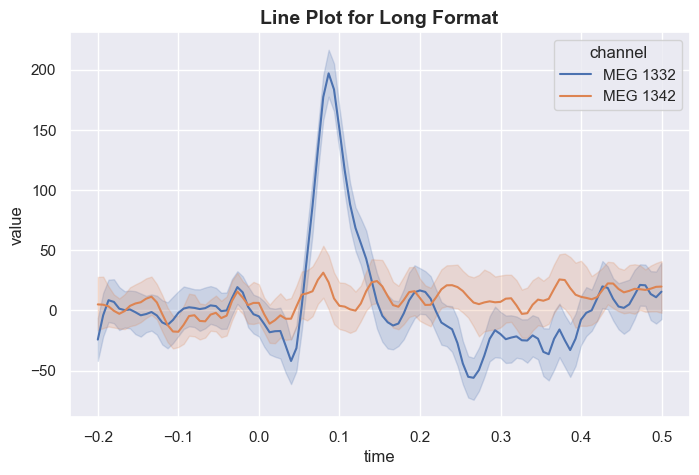

In [18]:
# reset index to increase speed
data_plot.reset_index(drop = True, inplace = True)

# plot
long_plot = sns.lineplot(data = data_plot, 
                         x = 'time', 
                         y = 'value', 
                         hue = 'channel')

# title style
long_plot.set_title("Line Plot for Long Format", 
                    fontdict=font_dict)

# Plot Latency of Peak Activation

Find the latency of peak activation of 2 gradiometers (one near auditory cortex and one near visual cortex), and plot the distribution of the timing of the peak in each channel:

In [19]:
epoch_df = epochs.to_data_frame(time_format=None)

display(epoch_df.shape)
display(epoch_df.head())

(26818, 379)

,time,condition,epoch,MEG 0113,MEG 0112,MEG 0111,MEG 0122,MEG 0123,MEG 0121,MEG 0132,MEG 0133,MEG 0131,MEG 0143,MEG 0142,MEG 0141,MEG 0213,MEG 0212,MEG 0211,MEG 0222,MEG 0223,MEG 0221,MEG 0232,MEG 0233,MEG 0231,MEG 0243,MEG 0242,MEG 0241,MEG 0313,MEG 0312,MEG 0311,MEG 0322,MEG 0323,MEG 0321,MEG 0333,MEG 0332,MEG 0331,MEG 0343,MEG 0342,MEG 0341,MEG 0413,MEG 0412,MEG 0411,MEG 0422,MEG 0423,MEG 0421,MEG 0432,MEG 0433,MEG 0431,MEG 0443,MEG 0442,MEG 0441,MEG 0513,MEG 0512,MEG 0511,MEG 0523,MEG 0522,MEG 0521,MEG 0532,MEG 0533,MEG 0531,MEG 0542,MEG 0543,MEG 0541,MEG 0613,MEG 0612,MEG 0611,MEG 0622,MEG 0623,MEG 0621,MEG 0633,MEG 0632,MEG 0631,MEG 0642,MEG 0643,MEG 0641,MEG 0713,MEG 0712,MEG 0711,MEG 0723,MEG 0722,MEG 0721,MEG 0733,MEG 0732,MEG 0731,MEG 0743,MEG 0742,MEG 0741,MEG 0813,MEG 0812,MEG 0811,MEG 0822,MEG 0823,MEG 0821,MEG 0913,MEG 0912,MEG 0911,MEG 0923,MEG 0922,MEG 0921,MEG 0932,...,MEG 2433,MEG 2432,MEG 2431,MEG 2442,MEG 2443,MEG 2441,MEG 2512,MEG 2513,MEG 2511,MEG 2522,MEG 2523,MEG 2521,MEG 2533,MEG 2532,MEG 2531,MEG 2543,MEG 2542,MEG 2541,MEG 2612,MEG 2613,MEG 2611,MEG 2623,MEG 2622,MEG 2621,MEG 2633,MEG 2632,MEG 2631,MEG 2642,MEG 2643,MEG 2641,STI 001,STI 002,STI 003,STI 004,STI 005,STI 006,STI 014,STI 015,STI 016,EEG 001,EEG 002,EEG 003,EEG 004,EEG 005,EEG 006,EEG 007,EEG 008,EEG 009,EEG 010,EEG 011,EEG 012,EEG 013,EEG 014,EEG 015,EEG 016,EEG 017,EEG 018,EEG 019,EEG 020,EEG 021,EEG 022,EEG 023,EEG 024,EEG 025,EEG 026,EEG 027,EEG 028,EEG 029,EEG 030,EEG 031,EEG 032,EEG 033,EEG 034,EEG 035,EEG 036,EEG 037,EEG 038,EEG 039,EEG 040,EEG 041,EEG 042,EEG 043,EEG 044,EEG 045,EEG 046,EEG 047,EEG 048,EEG 049,EEG 050,EEG 051,EEG 052,EEG 053,EEG 054,EEG 055,EEG 056,EEG 057,EEG 058,EEG 059,EEG 060,EOG 061
0,-0.199795,visual/left,1,21.320252,11.567619,-73.248584,-10.609895,-18.700540,-68.352746,-17.908667,45.379736,-53.123525,10.837026,-17.542068,-71.290885,-66.553255,-15.586660,44.324378,29.821774,19.648534,94.193008,16.173039,11.598142,68.402902,-53.586722,86.109251,87.801113,-12.918468,-32.167849,29.115091,-38.921648,16.028165,16.292279,-32.295994,-35.527168,18.198490,-13.207553,13.475930,34.695472,40.876767,-11.151963,-13.587079,70.268641,-92.822186,-131.993398,38.207119,-22.823200,-273.091265,85.153234,31.090823,-54.229405,5.550650,-9.554881,97.801343,2.998546,41.128059,43.341383,-9.618887,15.429924,126.532189,3.175574,-25.459359,53.405968,21.820362,-23.555283,109.512231,48.747915,9.408847,-34.715907,-18.272625,-30.496417,-95.796209,55.427993,-9.239648,4.688691,-78.246355,30.743800,-116.479851,52.860140,-40.754460,26.469598,17.474393,102.590035,153.734896,39.946922,10.501063,-47.349012,3.875177,76.206536,-126.079301,13.691632,70.795812,-15.259354,20.009055,35.856302,-317.410795,32.992842,-31.305607,-259.482483,-2.320914,...,8.138109,22.536511,36.490027,0.377258,1287.880449,65.214875,11.142744,26.062752,-67.976876,21.882399,12.759388,-0.551705,23.004923,6.459737,-60.841530,-5.042030,38.888952,-109.732225,-3.236471,15.171023,147.329282,-15.880678,-4.399600,6.195110,26.734776,22.178507,30.358124,-36.450376,52.768824,26.327943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.645044,3.609961,-1.573908,3.246475,7.800427,2.055489,-1.960021,7.044293,3.832933,1.595152,5.743331,7.497882,8.022313,9.135800,-1.830512,-4.213223,-1.242835,-0.695870,-0.839391,1.609889,6.592527,2.034627,-4.053290,-2.743959,-2.177945,-0.054796,-2.396793,-3.390592,-0.477600,1.385716,4.478962,4.257392,2.202634,4.168788,-4.910960,-5.477194,-3.930414,-3.245296,-1.474465,2.086504,1.951046,-0.308536,-4.639212,-4.585155,-4.281437,-1.690524,-2.689095,-0.121264,1.289970,2.705279,1.040743,-1.313214,-0.758163,-4.140469,-1.692072,-3.615114,-5.109115,-4.763071,0.593029,-8.698777,1.785416
1,-0.193135,visual/left,1,7.049675,-9.702938,-34.168267,17.480975,-40.182237,-121.225684,2.072452,27.734826,-95.339465,5.517672,2.229642,21.344793,-50.223884,-3.740594,-103.975528,6.674078,25.638868,-90.168324,-2.769242,65.028595,3.634512,-41.262929,137.139203,61.055024,-1.437523,-69.523614,23.020498,-

In [20]:
peak_latency = (epoch_df.filter(regex=r'condition|epoch|MEG 1332|MEG 2123')
                .groupby(['condition', 'epoch'])
                .aggregate(lambda x: df['time'].iloc[x.idxmax()])
                .reset_index()
                .melt(id_vars = ['condition', 'epoch'],
                      var_name = 'channel',
                      value_name = 'latency of peak')
                )

peak_latency["LATENCY_OF_PEAK"] = peak_latency['latency of peak'].apply(lambda x: x.total_seconds())
peak_latency.drop(columns=["latency of peak"], inplace = True)

display(peak_latency.shape)
display(peak_latency.head())

(506, 4)

,condition,epoch,channel,LATENCY_OF_PEAK
0,auditory/left,2,MEG 1332,0.099897
1,auditory/left,6,MEG 1332,0.186475
2,auditory/left,10,MEG 1332,0.372951
3,auditory/left,14,MEG 1332,0.366291
4,auditory/left,19,MEG 1332,0.079918


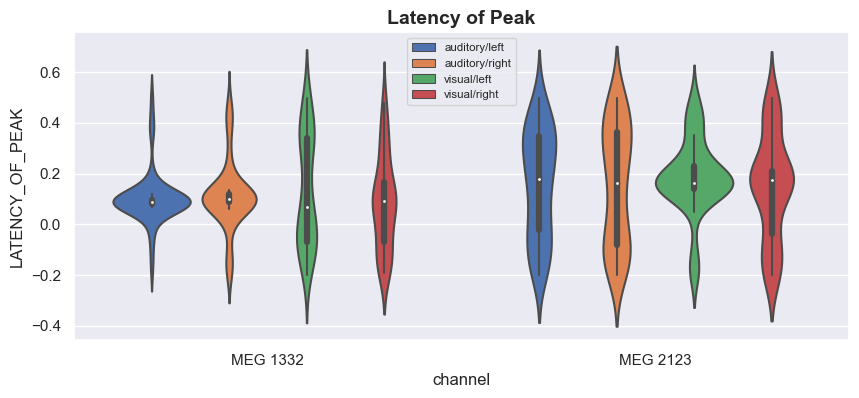

In [21]:
sns.set(rc = {"figure.figsize":(10,4)})
g = sns.violinplot(data = peak_latency,
                    x = 'channel', 
                    y = 'LATENCY_OF_PEAK', 
                    hue = 'condition',
                    palette='deep', saturation=1)
g.set_title("Latency of Peak", fontdict = font_dict)
g.legend(loc = 'upper center', fontsize = 'x-small')

__Random Selection of Channels__

In [22]:
def plot_line_random_chs(num_channels, ch_filter = "MEG"):
    
    channel_names = list(fif_info['ch_names'])
    ch_filter = [x for x in channel_names if str(x).startswith(str(ch_filter).upper())]
    channel_choices = random.choices(ch_filter, k = num_channels)
    
    print("Channel choices: ", channel_choices)
    
    # query data
    data_plot = long_df.loc['auditory/left'].copy()
    data_plot = data_plot.loc[data_plot["channel"].isin(channel_choices)]

    # concert channel to str to enhance visualization look-and-feel
    data_plot['channel'] = data_plot['channel'].astype(str)
    

    # reset index to increase speed
    data_plot.reset_index(drop = True, inplace = True)

    # plot
    long_plot = sns.lineplot(data = data_plot, 
                             x = 'time', 
                             y = 'value', 
                             hue = 'channel')

    # title style
    long_plot.set_title("Line Plot for Long Format", 
                        fontdict=font_dict)

Channel choices:  ['MEG 0231', 'MEG 2411', 'MEG 2342']


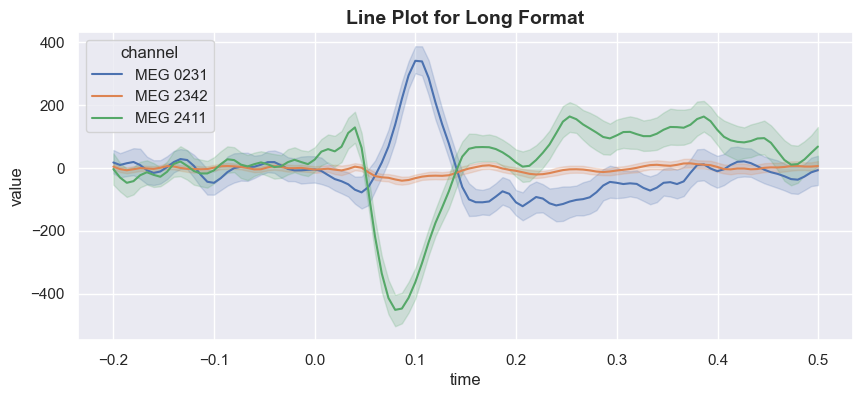

In [23]:
plot_line_random_chs(3, ch_filter = "MEG")

Channel choices:  ['EEG 024', 'EEG 004', 'EEG 054']


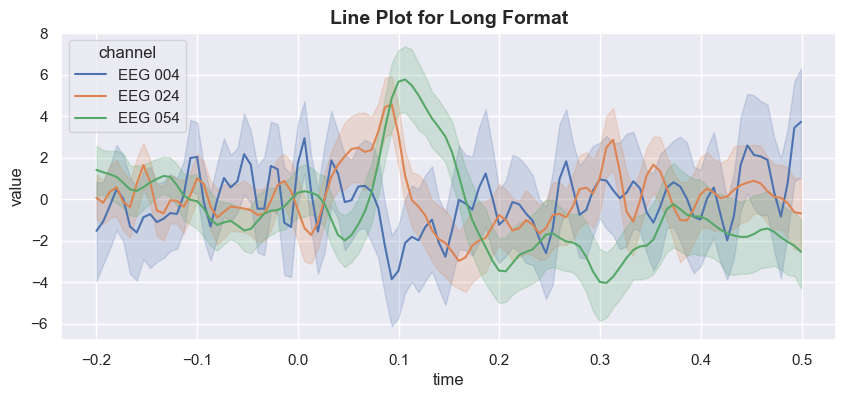

In [24]:
plot_line_random_chs(3, ch_filter = "eeg")

Channel choices:  ['MEG 1242', 'MEG 0121', 'MEG 1441']


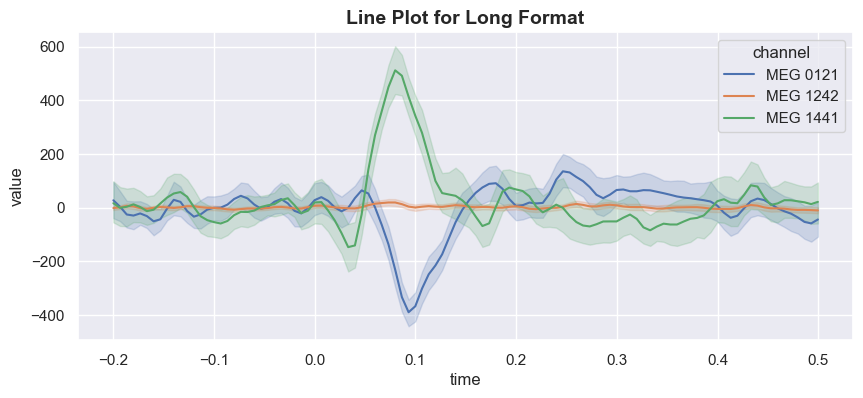

In [25]:
plot_line_random_chs(3, ch_filter = "meg")

Channel choices:  ['MEG 1543', 'MEG 1341', 'MEG 0531', 'MEG 2113']


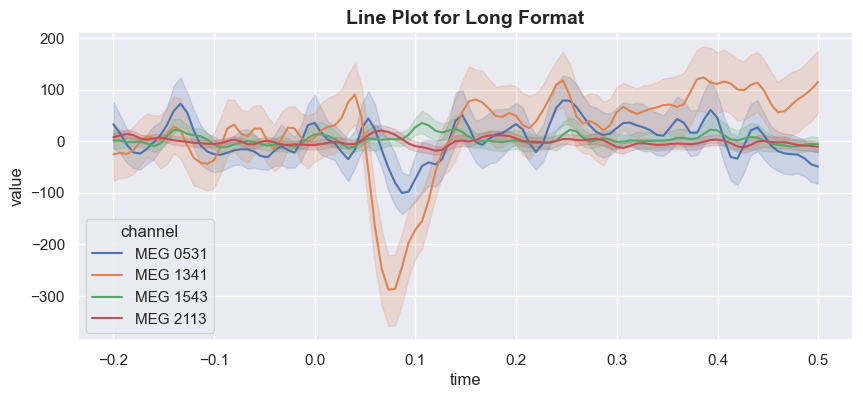

In [26]:
plot_line_random_chs(4, ch_filter = "meg")